<a href="https://colab.research.google.com/github/pvenkatt/DLL/blob/main/incept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies
**Importing the necessary dependencies**


---



In [ ]:
import os
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import matplotlib.pyplot as plt

# Dataset
Downloading dataset from Kaggle!


In [ ]:
!kaggle datasets download belalelwikel/asl-and-some-words

Loading dataset from google drive:

In [ ]:
! unzip /content/drive/MyDrive/archive.zip


In [8]:
training_dir=r'/content/ASL'

In [9]:
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['1', '3', '4', '5', '7', '8', '9', 'A', 'B', 'Baby', 'Brother', 'C', 'D', 'Dont_like', 'E', 'F', 'Friend', 'G', 'H', 'Help', 'House', 'I', 'J', 'K', 'L', 'Like', 'Love', 'M', 'Make', 'More', 'N', 'Name', 'No', 'O_OR_0', 'P', 'Pay', 'Play', 'Q', 'R', 'S', 'Stop', 'T', 'U', 'V_OR_2', 'W_OR_6', 'With', 'X', 'Y', 'Yes', 'Z', 'nothing']


51

# Input Preprocessing:
Using image data generator to generate test and validation directories

In [10]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)
train_generator = data_generator.flow_from_directory(
    training_dir, target_size=(200,200), 
    shuffle=True, seed=13,
    class_mode='categorical', 
    batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(
    training_dir, target_size=(200, 200),
    shuffle=True, seed=13,
    class_mode='categorical', 
    batch_size=64, subset="validation")

Found 182700 images belonging to 51 classes.
Found 20300 images belonging to 51 classes.


# **INCEPTION V3**
Making use of pretrained inception model's weights:

In [11]:
WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [12]:
inception_v3_model = keras.applications.inception_v3.InceptionV3(
    input_shape = (200, 200, 3), 
    include_top = False, 
    weights = 'imagenet'
)

inception_v3_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [13]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [14]:
from tensorflow.keras import layers
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                  
x = layers.Dense(51, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
import tensorflow as tf


# CALLBACK 
Using callbacks to stop the training when the validation accuracy hits 95%

In [16]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

# **Training the model:**
50 epochs, 200 steps in each with a batch size of 64

In [17]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
200/200 [==============================] - 226s 1s/step - loss: 3.9417 - acc: 0.0452 - val_loss: 3.8033 - val_acc: 0.0794
Epoch 2/50
200/200 [==============================] - 202s 1s/step - loss: 3.6467 - acc: 0.1515 - val_loss: 3.5539 - val_acc: 0.1756
Epoch 3/50
200/200 [==============================] - 202s 1s/step - loss: 3.3165 - acc: 0.2980 - val_loss: 3.2191 - val_acc: 0.3009
Epoch 4/50
200/200 [==============================] - 201s 1s/step - loss: 2.9288 - acc: 0.4284 - val_loss: 2.7930 - val_acc: 0.4062
Epoch 5/50
200/200 [==============================] - 202s 1s/step - loss: 2.5504 - acc: 0.5211 - val_loss: 2.4211 - val_acc: 0.4988
Epoch 6/50
200/200 [==============================] - 206s 1s/step - loss: 2.1855 - acc: 0.6065 - val_loss: 2.0462 - val_acc: 0.5872
Epoch 7/50
200/200 [==============================] - 200s 998ms/step - loss: 1.9003 - acc: 0.6605 - val_loss: 1.7634 - val_acc: 0.6513
Epoch 8/50
200/200 [==============================] - 201s 1s/step

**Total time taken to train the model**: 2.3625hrs = 2 hrs 21 mins 45 secs lol ⚡❗


Saving the trained model into hdf5 format

In [18]:
model.save('sign.h5')

**Copying the saved model into gdrive:**

In [19]:
import shutil
shutil.copy('/content/sign.h5','/content/drive/MyDrive/signdll')

'/content/drive/MyDrive/signdll/sign.h5'

# **Metrics:**
Plotting Training and Validation accuracy values at each epoch:

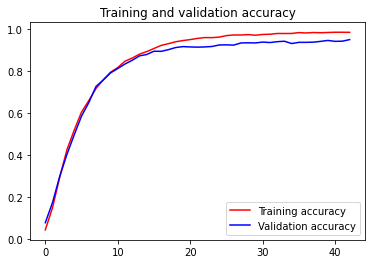

<Figure size 432x288 with 0 Axes>

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

Plotting Training and Validation loss values at each epoch:

<Figure size 432x288 with 0 Axes>

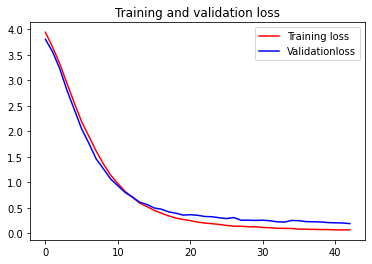

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()